In [1]:
import os
import time

from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import torch

from model import SAT
from util import CocoCaptionDataset, load_square, prepare_image

In [2]:
def make_visual(model, valid_ds, idx,
            beamk, max_gen_length, temperature,
            sample_method, sample_topk, decoder_noise,
            rescore_method, rescore_reward,
            show_topk=1):
    visual_size = 256
    scale = 5
    font_scale = 5
    columns = 4
    labelpad = 4

    print(f"{idx = }")

    img_path = valid_ds.img_paths[idx]
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    references = [c[1:l] for c, l in zip(valid_ds.encoded_captions[idx], valid_ds.lengths[idx])]
    gt_captions = [" ".join(valid_ds.itos(t) for t in r) for r in references]

    title_str = f"{img_name}\n"
    for i in range(len(gt_captions)):
        cap_str = f"Caption {i} : {gt_captions[i]}"
        title_str += cap_str + "\n"
        print(cap_str)

    img_pil = load_square(img_path, size=visual_size)
    img_ten = prepare_image(img_pil, size=model.hparams.input_size).to(model.device)
    t0 = time.time()
    captions, scores, alphas, perplexities = model.caption(img_ten, beamk, max_gen_length, temperature, sample_method, sample_topk, decoder_noise, rescore_method, rescore_reward, return_all=True)
    duration = time.time()-t0
    infer_str = f"Inference in {(duration*1e3):.2f} ms for {beamk=} and length={max([len(c) for c in captions[0]])}"
    infer_str += "\n" + f"{temperature=} {sample_method=} {decoder_noise=} {rescore_method=} {rescore_reward=}"
    title_str += infer_str + "\n"
    print(infer_str)

    for i in range(min(beamk, show_topk)):
        words = model.decode_seq(captions[0][i])
        pred_str = f"Prediction {i} (s={scores[0][i]:.2f}, p={perplexities[0][i]:.2f}) : {' '.join(words)}"
        title_str += pred_str + "\n"
        print(pred_str)

    num_sentences = 1 # min(beamk, show_topk)
    references_list = [references for i in range(num_sentences)]
    captions_list = captions[0][:num_sentences]
    bleu1 = corpus_bleu(references_list, captions_list, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references_list, captions_list, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references_list, captions_list, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references_list, captions_list, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_str = f"{bleu1 = :.4f}. {bleu2 = :.4f}. {bleu3 = :.4f}. {bleu4 = :.4f}"
    title_str += bleu_str
    print(bleu_str)

    map_size = model.hparams.encoder_size
    cap_len = len(captions[0][0])
    num_figs = 2+cap_len
    if cap_len<columns: columns=num_figs
    rows = 1 + num_figs//columns

    # Boost the height a little based on output length
    boost = 1 + (8+num_sentences)/(8*scale*font_scale+num_sentences)
    fig = plt.figure(figsize=[scale*columns, boost*scale*rows])
    fig.patch.set_facecolor('w')
    fig.suptitle(title_str, fontsize=scale*font_scale, x=0.03, y=1, horizontalalignment='left')

    # Color image
    plt.axis('off')
    fig.add_subplot(rows, columns, 1)
    ax = plt.gca()
    ax.imshow(img_pil)
    ax.set_xlabel("<START>", fontsize=scale*font_scale, labelpad=labelpad)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    words = model.decode_seq(captions[0][0])
    atts = alphas[0][0]

    # Attention Alphas
    i = 0  # Failsafe if the prediction is blank
    for i in range(cap_len):
        fig.add_subplot(rows, columns, i+2)
        ax = plt.gca()
        att = atts[i].reshape(map_size, map_size).cpu().numpy()
        att = ( (att-np.min(att))/(np.max(att)-np.min(att)) )**5.0
        mask = Image.fromarray(np.uint8(att*255)).convert('RGB').resize((visual_size, visual_size))
        img = ax.imshow(img_pil)
        ax.imshow(mask, cmap='gray', alpha=0.75, extent=img.get_extent())
        ax.set_xlabel(words[i], fontsize=scale*font_scale, labelpad=labelpad)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    fig.add_subplot(rows, columns, i+3)
    ax = plt.gca()
    att = atts.sum(0).reshape(map_size, map_size).cpu().numpy()
    att = (att-np.min(att))/(np.max(att)-np.min(att))
    mask = Image.fromarray(np.uint8(att*255)).convert('RGB').resize((visual_size, visual_size))
    ax.imshow(mask)
    ax.set_xlabel("Total Attention", fontsize=scale*font_scale, labelpad=labelpad)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    fig.tight_layout()

    plt.savefig(f"data/visualize/{img_name}_result.jpg", bbox_inches="tight")


In [3]:
checkpoint_path = "logs/default/version_131/last.ckpt"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SAT.load_from_checkpoint(checkpoint_path, map_location=device).to(device)
model.freeze()
valid_ds = CocoCaptionDataset(jsonpath=model.hparams.json, split="test")

C:\Users\lukeasargen\anaconda3\envs\pytorch19c11\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))
C:\Users\lukeasargen\anaconda3\envs\pytorch19c11\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


idx = 1417
Caption 0 : a man leaning over a lot as another man catches the frisbee
Caption 1 : a group of men playing in a grassy field with a <UNK>
Caption 2 : the action in a <UNK> sport <UNK> a white disc
Caption 3 : teenage boys playing a game of disc football in large open field
Caption 4 : a man <UNK> forward towards a frisbee next to three other men
Inference in 67.00 ms for beamk=10 and length=18
temperature=1.0 sample_method='topk' decoder_noise=0.0 rescore_method='LN' rescore_reward=1.0
Prediction 0 (s=-1.54, p=4.65) : a group of people playing a frisbee game in the sand
Prediction 1 (s=-1.58, p=4.88) : a group of people playing a frisbee in the sand
Prediction 2 (s=-1.75, p=5.77) : two people playing a game with frisbee on the sand
Prediction 3 (s=-2.01, p=7.46) : a group of young boys playing frisbee on top field
Prediction 4 (s=-2.21, p=9.13) : two people playing a game with frisbee on top of a sandy field with a <UNK>
bleu1 = 0.8182. bleu2 = 0.5721. bleu3 = 0.3350. bleu4 

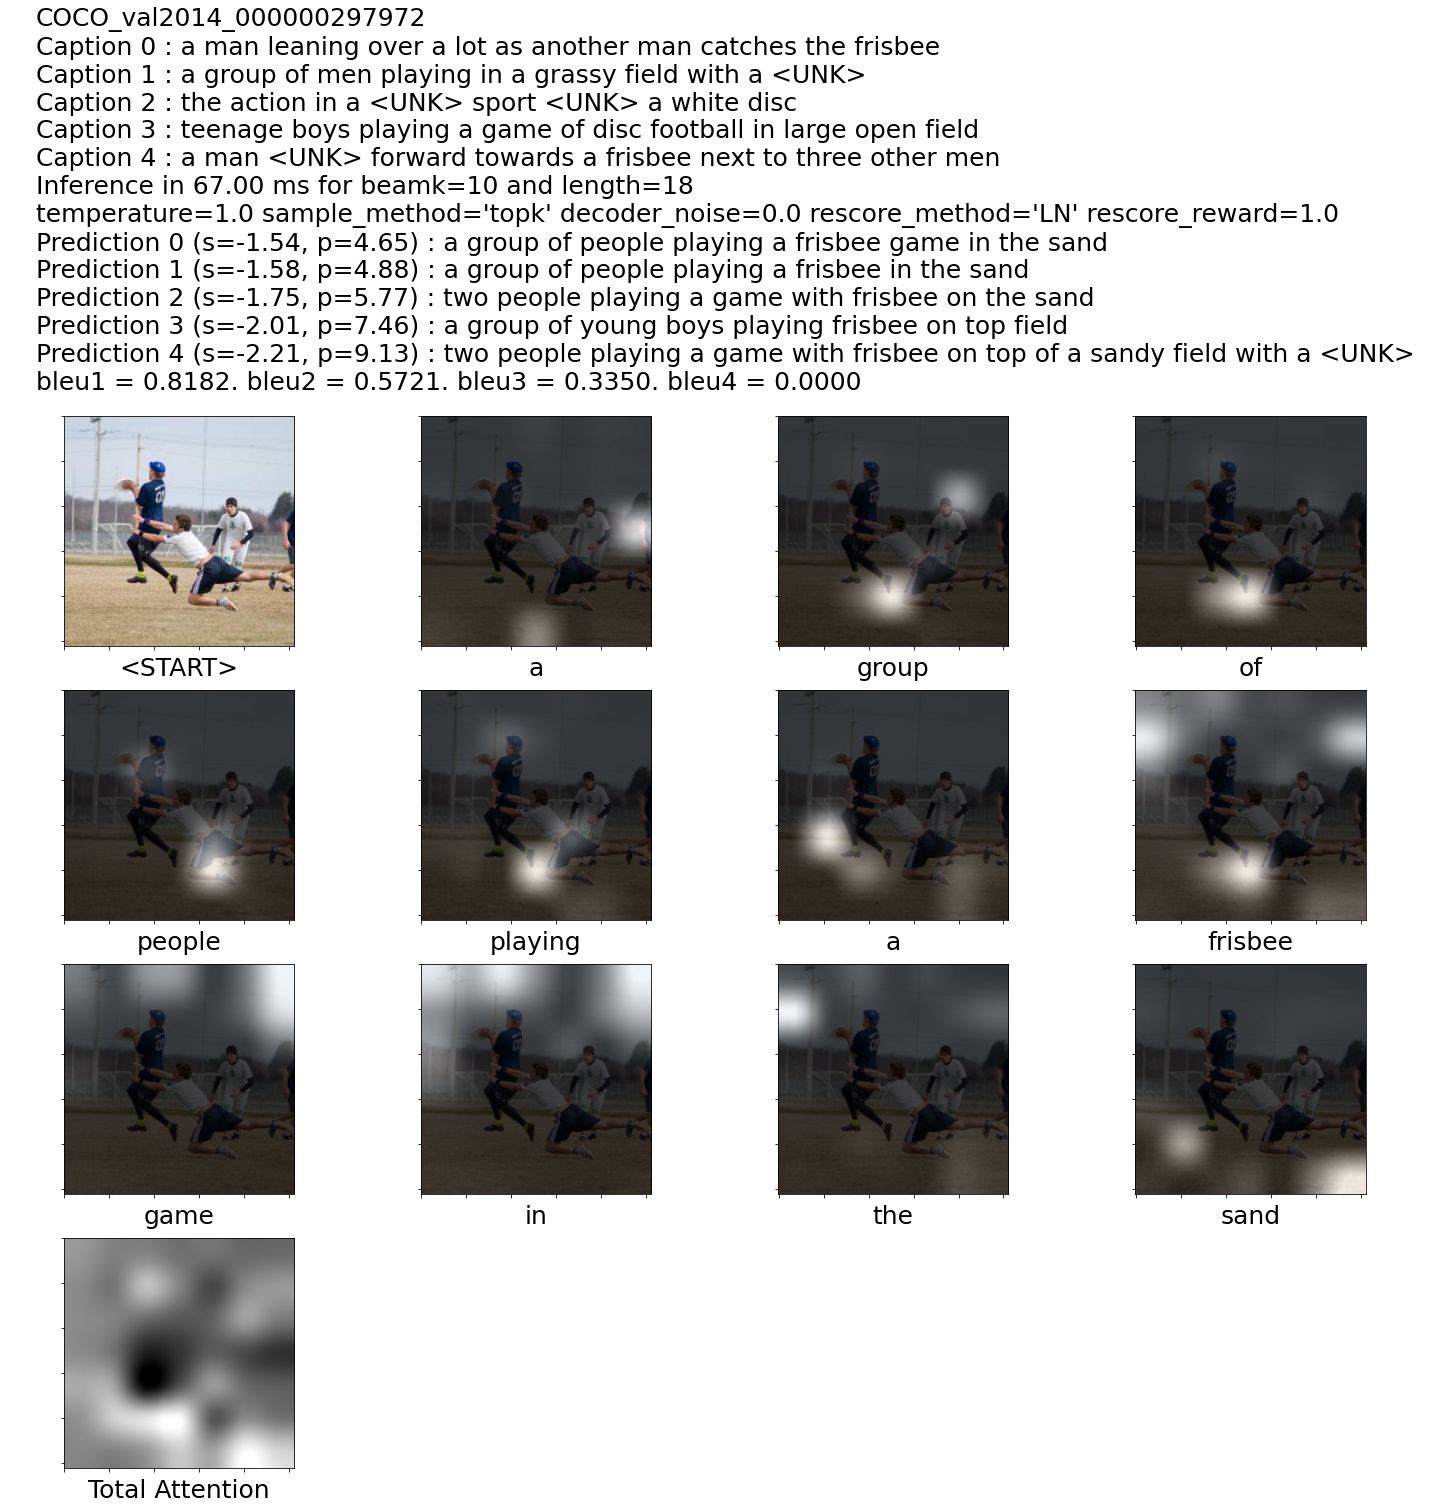

In [37]:
idx = np.random.randint(0, len(valid_ds.img_paths))
# idx = 2008

show_topk = 5
beamk = 10
max_gen_length = 32
# temperature = [1.0, 0.5, 0.5]
temperature = 1.0
sample_method = "topk"  # beam, multinomial, topk
sample_topk = 3
decoder_noise = 0.0
rescore_method = "LN"  # None, LN, WR, BAR
rescore_reward = 1.0

make_visual(model, valid_ds, idx, beamk, max_gen_length, temperature, sample_method, sample_topk, decoder_noise, rescore_method, rescore_reward, show_topk)